In [1]:
# 导包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from keras.utils import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import  imagenet_utils
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,LearningRateScheduler
from efficientnet.keras import EfficientNetB5

Using TensorFlow backend.


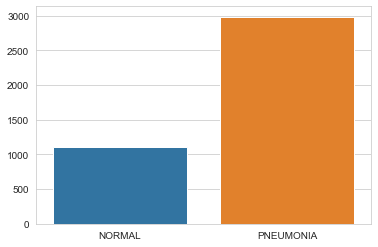

In [2]:
# EDA探索数据
import matplotlib.pyplot as plt
import seaborn as sns
import os

train_dir_path = "./xray_dataset/train"
train_normal_path = os.path.join(train_dir_path,"NORMAL")
train_pneumonia_path = os.path.join(train_dir_path,"PNEUMONIA")
train_normal_length = len(os.listdir(train_normal_path))
train_pneumonia_length = len(os.listdir(train_pneumonia_path))

sns.set_style("whitegrid")
sns.barplot(x = ["NORMAL","PNEUMONIA"],y = np.array([train_normal_length,train_pneumonia_length]))

In [3]:
img_rows,img_cols = 224,224
batch_size= 8

In [4]:
# ImageDataGenerator读取数据
from keras.preprocessing.image import ImageDataGenerator
import os


train_path = "C:\\Users\\LvChaoZhang\\00contest\\09 ai研习社胸腔X光肺炎检测\\xray_dataset\\train"


# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                                               shear_range = 0.2,
#                                                               zoom_range = 0.2,
#                                                               horizontal_flip = True,
#                                                               vertical_flip=True,
#                                                               validation_split=0.2,
#                                                               fill_mode="nearest")
train_datagen = ImageDataGenerator(rescale = 1./255,
                                                              validation_split=0.2)

train_set = train_datagen.flow_from_directory(train_path,
                                                                            target_size=(img_rows,img_cols),
                                                                            batch_size=batch_size,
                                                                            color_mode="rgb",
                                                                            class_mode="binary",
                                                                            shuffle=True,
                                                                            seed=2019,
                                                                            subset="training")
val_set = train_datagen.flow_from_directory(train_path,
                                                                      target_size=(img_rows,img_cols),
                                                                      batch_size=batch_size,
                                                                      class_mode="binary",
                                                                      color_mode="rgb",
                                                                      shuffle=False,
                                                                      subset="validation")

Found 3280 images belonging to 2 classes.
Found 819 images belonging to 2 classes.


In [5]:
train_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# 初始模型
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(img_rows,img_cols,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(units=256,activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
# 模型 VGG161.0
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(img_rows,img_cols,3))
for layer in base_model.layers:
    layer.trainable=False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(1,activation="sigmoid")(x)
model = Model(base_model.input,out)

In [ ]:
# 模型 2.0
model = Sequential()

model.add(Conv2D(10,(5,5),input_shape=(img_rows,img_cols,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(10,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# model.add(Dense(units=256,activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(units=128,activation='relu'))

#model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
# 模型 3.0
# 初始模型
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(img_rows,img_cols,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))

In [6]:
# 模型4.0

model = Sequential()

scale = 32

# convolution 1 
model.add(Conv2D(scale,(3,3),input_shape=(img_rows,img_cols,3)))
model.add(LeakyReLU(alpha=0.1))
# convolution 2
model.add(Conv2D(2*scale,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# convolution 3
model.add(Conv2D(3*scale,(3,3)))
model.add(LeakyReLU(alpha=0.1))
# convolution 4
model.add(Conv2D(4*scale,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# convolution 5
model.add(Conv2D(5*scale,(3,3)))
model.add(LeakyReLU(alpha=0.1))
# convolution 6
model.add(Conv2D(3*scale,(3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# convolution 7
model.add(Conv2D(6*scale,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# convolution 8
model.add(Conv2D(7*scale,(3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# flatten layer
model.add(Flatten())

# first dense layer
model.add(Dense(units=15*scale))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# second dense layer
model.add(Dense(units=15*scale))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# third dense layer
model.add(Dense(units=15*scale))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1,activation="sigmoid"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
# 试验模型Efficientnet
base_model = EfficientNetB5(weights="imagenet",include_top=False,input_shape=(img_rows,img_cols,3))
for layer in base_model.layers:
    layer.trainable=False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10,activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(1,activation="sigmoid")(x)
model = Model(base_model.input,out)

115515392/115515256 [==============================] - 530s 5us/step


In [12]:
# 模型编译
import keras.backend as K

# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [13]:
model.compile(loss=focal_loss(),metrics=["accuracy"],optimizer=Adam(lr=0.0001))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# Implement Learning rate decay
checkpoint = ModelCheckpoint("chest_xray_cnn2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1)
                              #min_delta = 0.00001)


callbacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
from sklearn.utils import class_weight
classweight = class_weight.compute_class_weight("balanced",np.unique(train_labels),train_labels)
print(classweight)
# class_weight={0:1.84307554 ,1:0.68613994}

In [16]:
# 训练
history = model.fit_generator(train_set,
                                 steps_per_epoch=3280//batch_size,
                                 epochs = 25,
                                 validation_data=val_set,
                                 validation_steps=819 //batch_size,
                                 shuffle=True,
                                 callbacks=callbacks)
                                 #class_weight={0:1.84307554 ,1:0.68613994})

Epoch 1/25
410/410 [==============================] - 107s 262ms/step - loss: 0.0402 - acc: 0.7561 - val_loss: 0.0581 - val_acc: 0.8027

Epoch 00001: val_loss did not improve from 0.05759
Epoch 2/25
410/410 [==============================] - 111s 271ms/step - loss: 0.0386 - acc: 0.7835 - val_loss: 0.0592 - val_acc: 0.7953

Epoch 00002: val_loss did not improve from 0.05759
Epoch 3/25
410/410 [==============================] - 109s 266ms/step - loss: 0.0385 - acc: 0.7979 - val_loss: 0.0592 - val_acc: 0.7953

Epoch 00003: val_loss did not improve from 0.05759
Epoch 4/25
410/410 [==============================] - 109s 267ms/step - loss: 0.0390 - acc: 0.7896 - val_loss: 0.0596 - val_acc: 0.7917

Epoch 00004: val_loss did not improve from 0.05759

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 5/25
410/410 [==============================] - 111s 271ms/step - loss: 0.0389 - acc: 0.8018 - val_loss: 0.0597 - val_acc: 0.7904

Epoch 00005: val_loss did not 

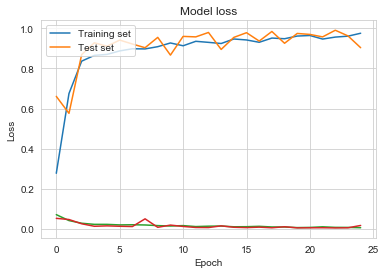

In [11]:
# 训练曲线
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Accuracy
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set","Validation Set"],loc="upper left")

# Loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training set","Test set"],loc="upper left")

plt.show()

In [ ]:
# 混淆矩阵
from keras.utils import to_categorical
from pathlib import Path
import cv2

base_dir = "./xray_dataset/train/"
normal_cases_dir = Path(base_dir + "NORMAL")
pneumonia_cases_dir = Path(base_dir + "PNEUMONIA")

normal_cases = normal_cases_dir.glob("*.jpeg")
pneumonia_cases = pneumonia_cases_dir.glob("*.jpeg")

train_data = []
train_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(224,224))
    if img.shape[2] == 1:
        img = np.dstack([img,img,img])
    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    #label = to_categorical(0,num_classes=2)
    label = 0
    train_data.append(img)
    train_labels.append(label)
    
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(224,224))
    if img.shape[2] == 1:
        img = np.dstack([img,img,img])
    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    #label = to_categorical(1,num_classes=2)
    label = 1
    train_data.append(img)
    train_labels.append(label)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

print("Total number of train examples:",train_data.shape)
print("Total number of labels:",train_labels.shape)

In [ ]:
train_loss,train_score = model.evaluate(train_data,train_labels)
print("Loss on the train:",train_loss)
print("Accuracy on train set:",train_score)

In [ ]:
preds = model.predict(train_data,batch_size=16)

In [ ]:
for i in range(len(preds)):
    if preds[i] > 0.5:
        preds[i] = 1
    else:
        preds[i] = 0
pred = preds[:,0]

In [ ]:
# 混淆矩阵
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(train_labels,pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2),["Normal","Pneumonia"],fontsize=16)
plt.yticks(range(2),["Normal","Pneumonia"],fontsize=16)
plt.show()

In [ ]:
# 计算精准率和召回率
tn,fp,fn,tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [ ]:
# ==== 预测 ===

In [13]:
import cv2
import numpy as np
import pandas as pd

# 定义读取图片函数
def  get_img(file_path,img_rows,img_cols):
    img = cv2.imread(file_path)
    img = cv2.resize(img,(img_rows,img_cols),interpolation=cv2.INTER_CUBIC)
#     if img.shape[2] == 1:
#         img = np.dstack([img,img,img])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    return img

In [14]:
# 定义加载测试集的函数
def load_test_data(test_path,img_rows,img_cols):
    x_test_id = []
    x_test = []

    img_names = os.listdir(test_path)
    img_names.sort(key=lambda x:int(x[:-5]))
    for img_name in img_names:
        feature = get_img(os.path.join(test_path,img_name),img_rows,img_cols)
        id = img_name

        x_test_id.append(id)
        x_test.append(feature)

    #对x_test进行转换
    x_test = np.array(x_test)

    return x_test,x_test_id

In [15]:
test_dir_path = "./xray_dataset/test/"

In [16]:
x_test,x_id = load_test_data(test_dir_path,img_rows,img_cols)

In [25]:
model.load_weights("chest_xray_cnn1.h5")

In [30]:
y_pred = model.predict(x_test)

In [31]:
y_pred[:10]

array([[2.5647879e-04],
       [1.6162097e-03],
       [9.9977380e-01],
       [4.3713784e-01],
       [9.9988210e-01],
       [8.4823644e-01],
       [5.0941110e-04],
       [3.3339858e-04],
       [1.0000000e+00],
       [8.8866949e-01]], dtype=float32)

In [32]:
for i in range(len(x_test)):
    if y_pred[i]>0.5:
        y_pred[i]=1;
    else:
        y_pred[i]=0;

In [33]:
id = np.arange(len(x_test))+1

In [34]:
df = pd.DataFrame({"id":id,"predict":y_pred[:,0]})

In [35]:
df.to_csv("submit30.csv",index=None,header=None)

### 知识总结

**一、Python环境中两种排序方案:**
 - 1. 用库函数sorted()对字符串排序，它的对象是字符
 - 2. 用函数sort()对数字排序，它的对象是数字，如果读取文件的话，需要进行处理（对文件后缀名进行"屏蔽"）

**1.测试库函数sorted()**

In [ ]:
import numpy as np
import os

img_path = "./img/"
img_list = sorted(os.listdir(img_path))
img_nums = len(img_list)
for i in range(img_nums):
    img_name = img_path + img_list[i]
    print(img_name)

**结果展示**
 - ./img/11.jpg
 - ./img/111.jpg
 - ./img/1111.jpg
 - ./img/221.jpg
 - ./img/23.jpg
 - ./img/32.jpg
 - ./img/4.jpg 

**运行结果:**
- ./img/4.jpg
- ./img/11.jpg
- ./img/23.jpg
- ./img/32.jpg
- ./img/111.jpg
- ./img/221.jpg
- ./img/1111.jpg

**2.测试函数sort()**

In [ ]:
import numpy as np
import os
img_path = "./img"

img_list = os.listdir(img_path)
img_list.sort(key=lambda x:int(x[:-4]))
img_nums = len(img_list)
for i in range(img_nums):
    img_name = img_path+img_list[i]
    print(img_name)

可以看出，文件名是按数字排序的，`sort函数中用到了匿名函数(key=lambda x:int(x[:-4]))`，其作用是将后缀名'.jpg"屏蔽（因为".jpg"是4个字符，所以[:-4]的含义是从文件名开始到倒数第四个字符为止）

### 二、常用的ModelCheckpoint、EarlyStopping、ReduceLROnPlateau

 - ModelCheckpoint:保存满足条件的性能最好的模型
 - EarlyStopping:用于提前停止蓄念的callbacks，具体的来说，就是可以loss减少的程度小于某个阈值的时候停止继续训练
 - ReduceLROnPlateau:当指标停止提升时，降低学习速率。


### 三、classweight

keras中加入了class_weight="auto"，设置了这个参数之后，keras会自动设置class weight让每类的sample对损失的共享相等。


In [ ]:
from sklearn.utils import class_weight
classweight = class_weight.compute_class_weight("balanced",np.unique(train_labels),train_labels)
print(classweight)

 - class_weight:主要针对数据不均衡的问题，比如：异常检测的二项分类问题，异常数据仅占1%，正常数据占99%；此时就要设置不同类对loss的影响。
 - sampl_weight:主要解决样本质量不同的问题，比如前1000个样本的可信度高，那么它的权重就要高，后1000个样本可能有错、不可信，那么权重就要调低。

### 四、focal loss

focal loss就是在cross_entropy_loss前加了权重，让模型注重于去学习更难以学习的样本，并在一定程度上解决类别不均衡问题。

关于交叉熵的文章：https://blog.csdn.net/tsyccnh/article/details/79163834

关于focal loss的文章：https://blog.csdn.net/MrR1ght/article/details/93649259

In [ ]:
def Cross_entropy_loss(y_true,y_pred):
    '''
    :param y_true: ont-hot encoding ,shape is [batch_size,nums_classes]
    :param y_pred: shape is [batch_size,nums_classes],each example defined as probability for per class
    :return:shape is [batch_size,], a list include cross_entropy for per example
    '''
    y_pred = K.clip(y_pred, K.epsilon(),1.0 - K.epsilon())
    crossEntropyLoss = -y_true * tf.log(y_pred)
 
    return tf.reduce_sum(crossEntropyLoss,-1)
 

In [ ]:
# 模型编译
import keras.backend as K

# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy